In [178]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

np.set_printoptions(precision=3, suppress=True)
print(tf.__version__)

2.6.0


In [179]:
csv_path = '/workspaces/python-nfl-stats-ml/src/input/RegularSeasonMLData.txt'
raw_df = pd.read_csv(csv_path)

# Copy the Raw Data to a new Dataframe
dataset = raw_df.copy()

# Clean out the N/A Values
dataset.dropna()

# Drop the unneeded items
dataset.pop('YearValue')
dataset.pop('WeekNumber')
dataset.pop('TypeId')



0       2
1       2
2       2
3       2
4       2
       ..
4979    2
4980    2
4981    2
4982    2
4983    2
Name: TypeId, Length: 4984, dtype: int64

In [180]:
# Build Training Set
train_dataset = dataset.sample(frac=0.8, random_state=0)

# Build the Test Data Set
test_dataset = dataset.drop(train_dataset.index)

#Plots
#sns.pairplot(train_dataset, vars=['YardsPerPass', 'PassingAttempts', 'OppDefYardsPerPassAllowed', 'PassYards', 'OppDefRedzoneEfficiency', 'OffenseEfficiency', 'PointsScored'], hue='Result', diag_kind='kde')


In [181]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

#Remove the Meta information
train_features.pop('Team')
train_features.pop('Opponent')
train_features.pop('IsHome')

test_features.pop('Team')
test_features.pop('Opponent')
test_features.pop('IsHome')

# Remove the other score information
train_features.pop('PointsAllowed')
train_features.pop('TotalPoints')
train_features.pop('PointDifferential')
train_features.pop('Result')

test_features.pop('PointsAllowed')
test_features.pop('TotalPoints')
test_features.pop('PointDifferential')
test_features.pop('Result')

train_labels = train_features.pop('PointsScored')
test_labels = test_features.pop('PointsScored')

# normalize features

normilizer = tf.keras.layers.Normalization(axis=-1)
normilizer.adapt(np.array(train_features))
#print(normilizer.mean.numpy())


In [182]:
# Regression On Offensive Efficiency
efficiency = np.array(train_features['OffenseEfficiency'])
efficiency_normalizer = layers.Normalization(input_shape=[1,], axis=None)
efficiency_normalizer.adapt(efficiency)

efficiency_model = tf.keras.Sequential([
  efficiency_normalizer,
  layers.Dense(units=1)
])

efficiency_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_41 (Normalizat (None, 1)                 3         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [183]:
efficiency_model.predict(efficiency[:10])

efficiency_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1),loss='mean_absolute_error')

history = efficiency_model.fit(
  train_features['OffenseEfficiency'],
  train_labels,
  epochs=100,
  verbose=0,
  validation_split=0.2)
hist = pd.DataFrame(history.history)
if 'epoch' in hist:
  hist['epoch'] = history.epoch
  hist.tail()

In [184]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0,10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Efficiency]')
  plt.legend()
  plt.grid(True)

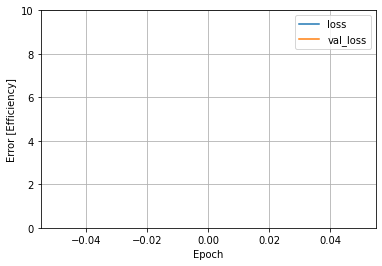

In [185]:
plot_loss(history)

In [186]:
test_results = {}
test_results['efficiency_model'] = efficiency_model.evaluate(
  test_features['OffenseEfficiency'],
  test_labels,
  verbose=0)

In [187]:
x = tf.linspace(0.0,250,251)
y = efficiency_model.predict(x)

In [188]:
def plot_efficiency(x, y):
  plt.scatter(train_features['OffenseEfficiency'], train_labels, label='Data')
  plt.plot(x,y, color='k', label='Predicitions')
  plt.xlabel('Efficiency')
  plt.ylabel('PointsScored')
  plt.legend()


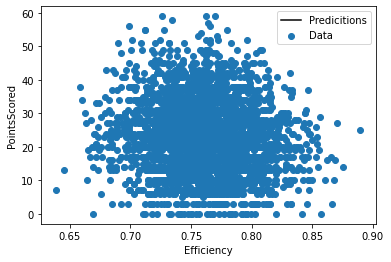

In [189]:
plot_efficiency(x,y)